In [2]:
from os import path
%matplotlib inline
from pyprojroot import here
workspace_path = '/Users/seyongpark/Projects/gravitational-lensing'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autolens as al
import autolens.plot as aplt
import matplotlib.pylab as plt
#plt.rcParams.update({'font.size': 6})
#plt.rcParams.update(plt.rcParamsDefault)

import numpy as np
from scipy.interpolate import griddata
from astropy.cosmology import FlatLambdaCDM
from scipy import ndimage

/Users/seyongpark/Projects/gravitational-lensing
Working Directory has been set to `/Users/seyongpark/Projects/gravitational-lensing`


## Functions

In [3]:
def create_grid(size,spacing,thickness,gradient=False):
    grid = np.zeros((size,size))
    num_lines = int(size/spacing)
    
    for i in range(num_lines):
        grid[:,spacing*i:(spacing*i+thickness)] = 10**(-7-4*i/num_lines) if gradient else 1
    for j in range(num_lines):
        grid[spacing*j:(spacing*j+thickness),:] = 10**(-7-4*j/num_lines) if gradient else 1
    return grid

def transform_image(image,angle,center,scale):
    pixel_shift = np.array([-center[0],center[1]])/scale
    transformed_image = image.native
    transformed_image = ndimage.rotate(transformed_image,angle,order=0,reshape=False)
    transformed_image = ndimage.shift(transformed_image,pixel_shift,order=0)    
    # return al.Array2D.no_mask(transformed_image,pixel_scales=scale)
    return transformed_image

def change_coordinates(source_plane,center,fov,scale):
    traced_grid = np.copy(source_plane)
    traced_grid[:,0] = (-traced_grid[:,0]+center[0]+fov/2)/scale
    traced_grid[:,1] = (traced_grid[:,1]+center[1]+fov/2)/scale
    return np.transpose(traced_grid)

def plot_image(image,center,fov,ax,title,**kwargs):
    #ax.contourf(X+0.02187,Y+7.52,magnif.native,levels=[70,100000],zorder=10)
    x_center = center[1]
    y_center = center[0]
    im = ax.imshow(
    np.log10(
        image,
        where=(image != 0),
        out=np.full_like(image, -15),
    )+6,
    extent=[
         x_center - fov / 2,
         x_center + fov / 2,
         y_center - fov / 2,
         y_center + fov / 2,
     ],
    cmap="inferno",
    vmin=-5,
    vmax=-1,
    **kwargs)
    ax.set(
    xlabel="arcsec", ylabel="arcsec"
    )
    # ax.set(xlabel='arcsec ({:.2f} " / pixel)'.format(detector_arcsec_per_pxl), ylabel="arcsec")
    ax.set_facecolor("black")
    ax.set_title(title)
    return im

## Source Image

In [4]:
# read in source and image plane from files computed by Ray Tracing.inpyb
traced_image_plane = al.Grid2D.no_mask(np.load("image_plane.npy"), pixel_scales=0.1)
traced_source_plane = al.Grid2D.no_mask(np.load("source_plane.npy"), pixel_scales=0.1)

# find index of location of earendel on image plane
index = np.where((abs(traced_image_plane[:,0]+29.2)<0.0025)\
         & (abs(traced_image_plane[:,1]-25)<0.0025))
# trace back to source plane
source_center = traced_source_plane[index][0]
print("Source Plane Center: ({:.3f}, {:.3f})".format(source_center[0],source_center[1]))

Source Plane Center: (-7.521, 0.022)


In [12]:
image_path = path.join("new2.fits")

# read in source image data
galaxy_image = al.Array2D.from_fits(
    file_path=image_path,
    pixel_scales=0.0001,
)

source_center = (-7.521, 0.022)
source_pix = galaxy_image.shape_native[0]
source_fov = source_pix*galaxy_image.pixel_scale

image_center = (-30,20)
detector_arcsec_per_pxl = 0.005
reco_image_fov = 20  # arcsec on one side
image_pix = int(reco_image_fov / detector_arcsec_per_pxl)

# define source plane
source_plane_grid_2d = al.Grid2D.uniform(
    shape_native=galaxy_image.shape_native,
    pixel_scales=galaxy_image.pixel_scale,
    origin=source_center
)

# transform traced grid coordinates to use with map_coordinates
traced_grid = change_coordinates(traced_source_plane, \
                                 center = source_center, \
                                 fov = source_fov, \
                                 scale = galaxy_image.pixel_scale)

## Convergence and Magnification

In [6]:
# read data
magnif_path = path.join("glafic-model",\
                        "hlsp_relics_model_model_whl0137-08_glafic_v1_z06p2-magnif.fits")
magnif = al.Array2D.from_fits(file_path=magnif_path,pixel_scales=0.1)
kappa_path = path.join("glafic-model","hlsp_relics_model_model_whl0137-08_glafic_v1_kappa.fits")
kappa = al.Array2D.from_fits(file_path=kappa_path,pixel_scales=0.1)

(-40.0, -20.0)

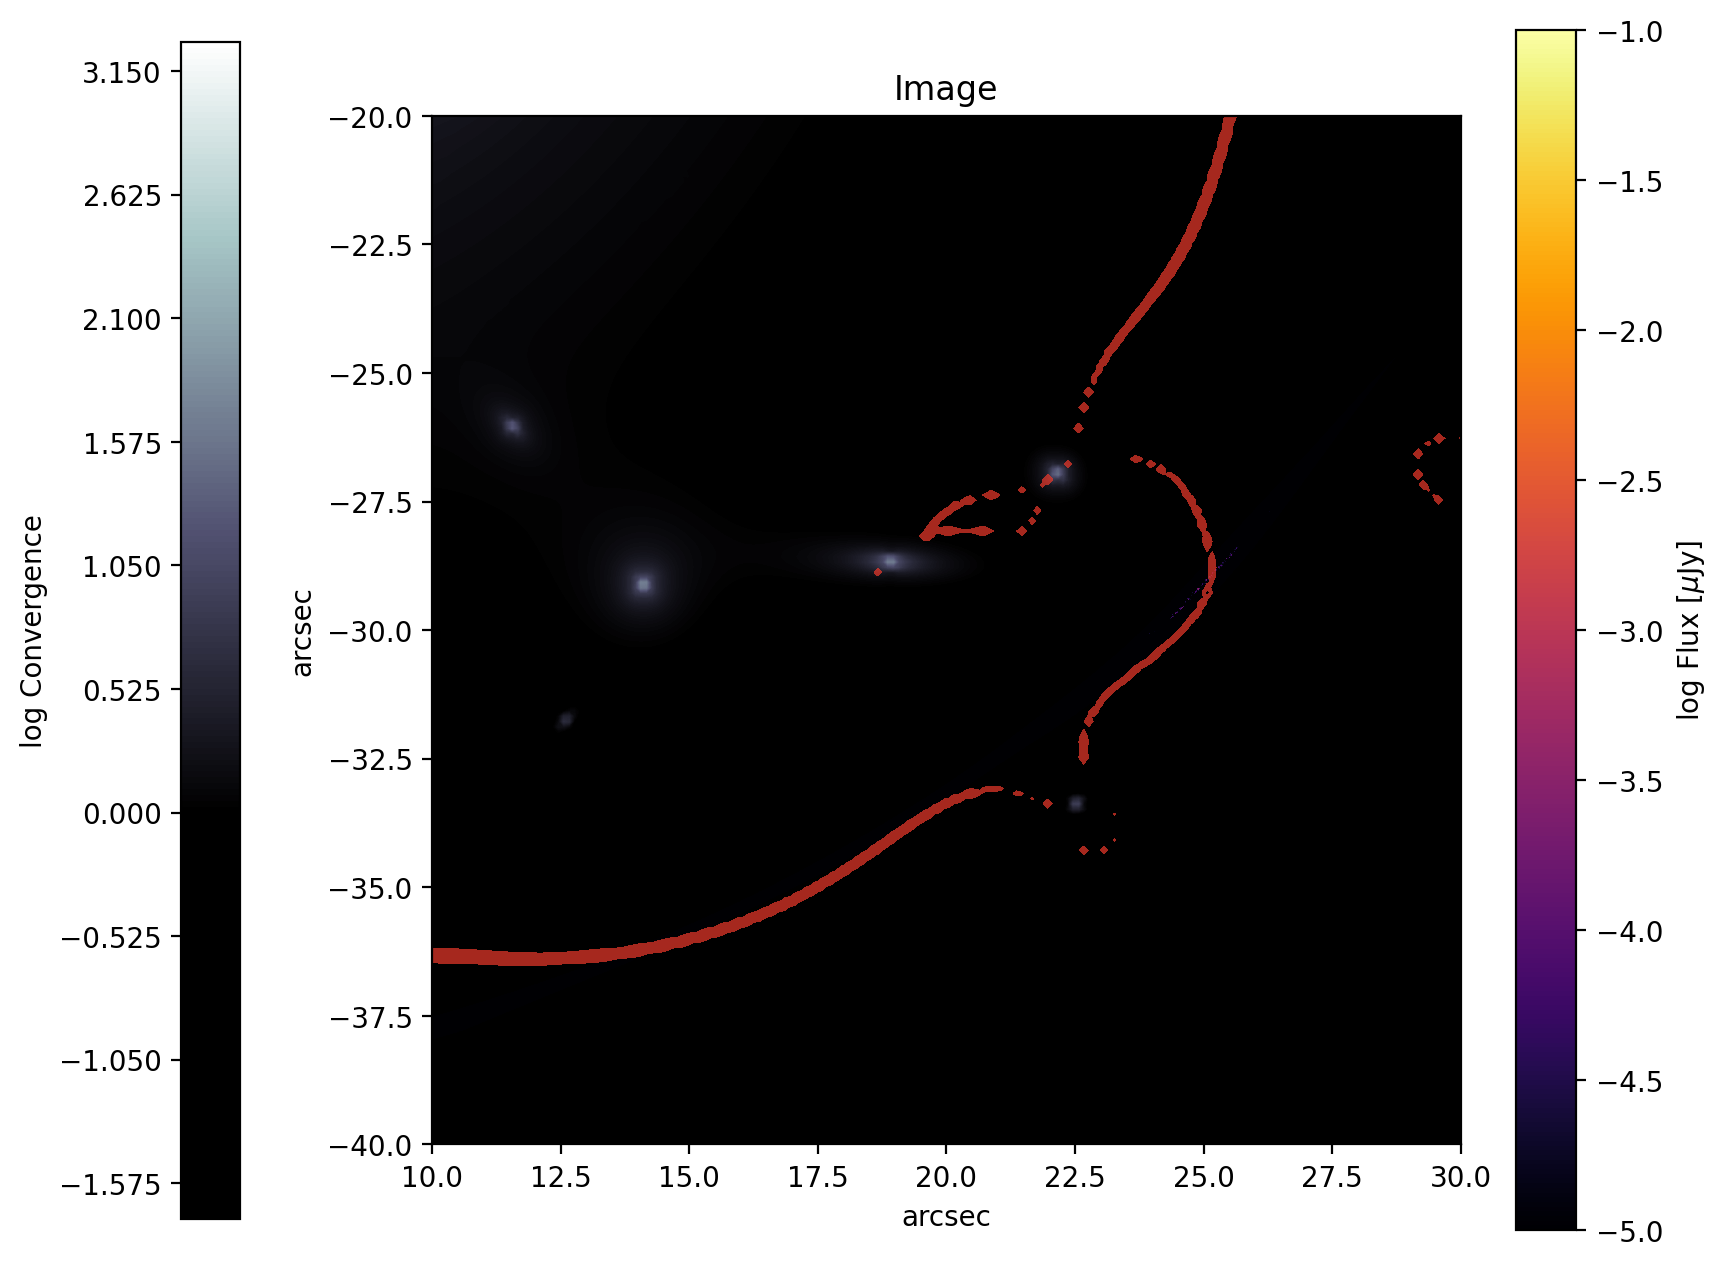

In [7]:
# compute grid values
N = 1200
x = np.linspace(-60, 60, N)
y = np.linspace(-60, 60, N)
X, Y = np.meshgrid(x, y)
Y = -Y # pyautolens and numpy use different conventions

# lens image
lensed_image = ndimage.map_coordinates(galaxy_image.native, traced_grid, order=1, cval=float('nan'))
lensed_image = np.reshape(lensed_image, (-1, int(reco_image_fov / detector_arcsec_per_pxl)))

fig, ax = plt.subplots(1, 1, figsize=(9, 9), dpi=200)

conv = plt.contourf(X,Y,np.log(kappa.native),levels=200,cmap="bone",vmin=0)
im = plot_image(lensed_image,image_center,reco_image_fov,ax,"Image",zorder=1)
magnif_line = plt.contourf(X,Y,magnif.native,levels=[500,100000],zorder=2, \
                           cmap="Reds",alpha=0.7,vmax=80000)
#plt.scatter(magnif_line_points[:,1],magnif_line_points[:,0],color="red",s=1)
fig.colorbar(im, label="log Flux [$\mu$Jy]",fraction=0.043, pad=0.04)
fig.colorbar(conv, label="log Convergence",fraction=0.046, pad=0.15,location="left")

ax.set_xlim([10,30])
ax.set_ylim([-40,-20])

## Lensed Images

(-8.0, -7.0)

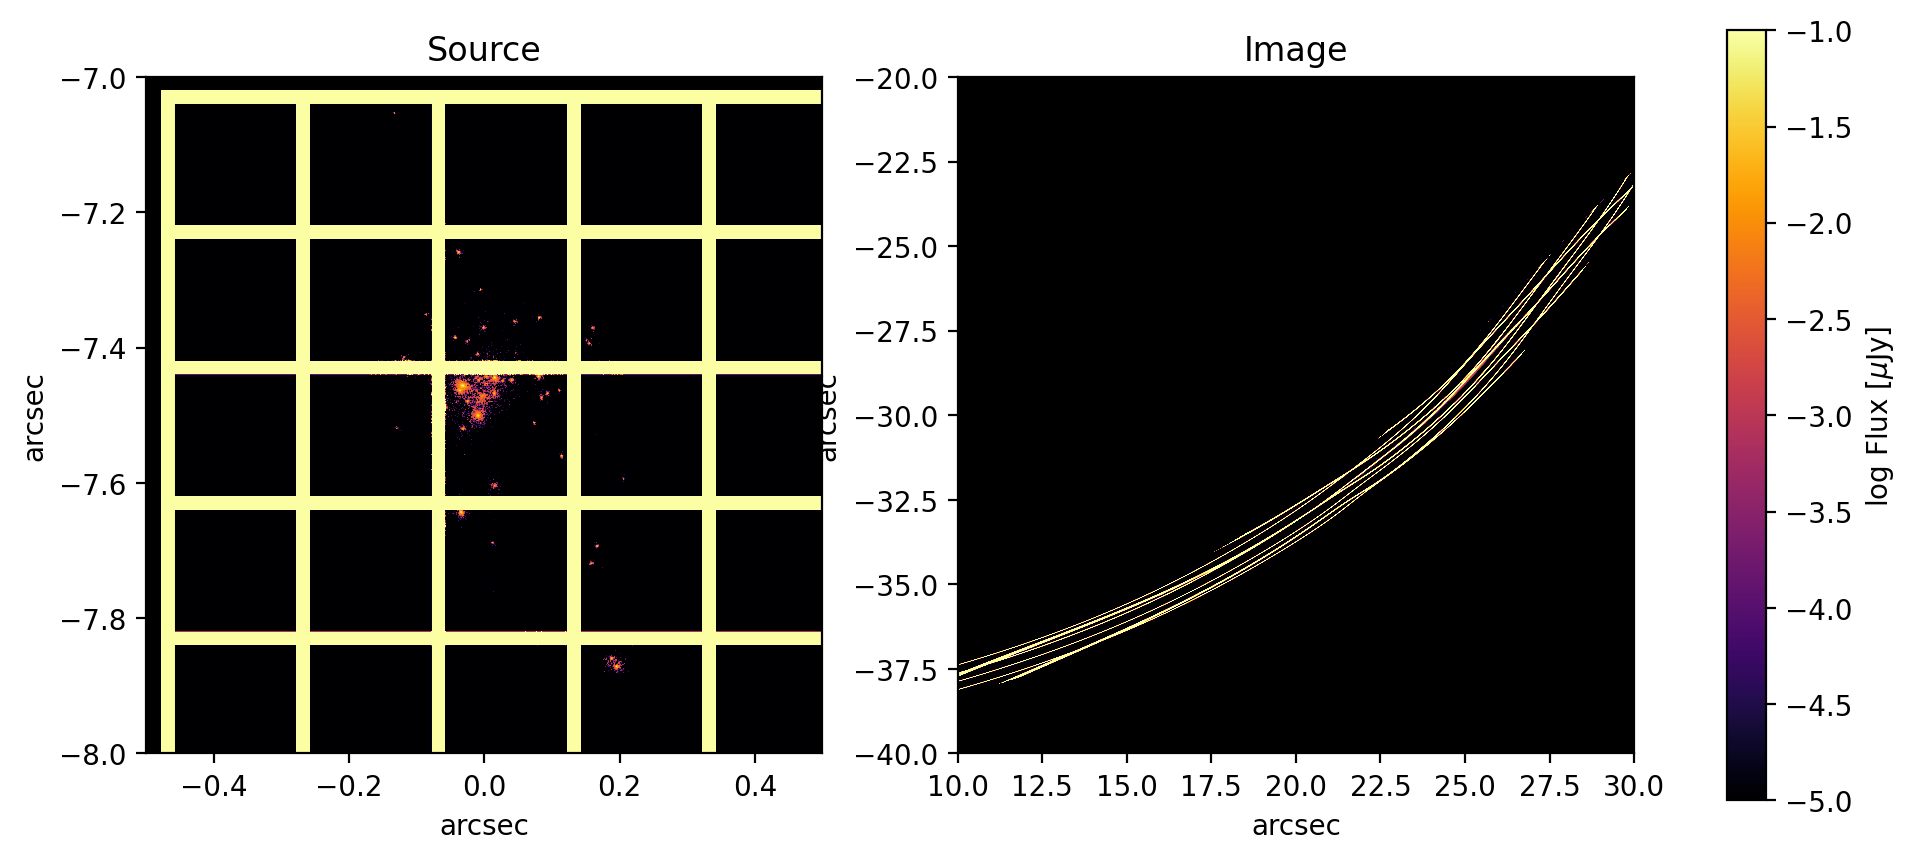

In [7]:
grid_image = al.Array2D.no_mask(create_grid(1000,200,20)+galaxy_image.native,pixel_scales=0.001)
# lens image
lensed_image = ndimage.map_coordinates(grid_image.native, traced_grid, order=1, cval=float('nan'))
lensed_image = np.reshape(lensed_image, (-1, int(reco_image_fov / detector_arcsec_per_pxl)))

# plot source image
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
im1 = plot_image(grid_image.native,source_center,source_fov,ax[0],"Source")
im2 = plot_image(lensed_image,image_center,reco_image_fov,ax[1],"Image")
fig.colorbar(im2, ax=ax, label="log Flux [$\mu$Jy]")
# plot center of source plane
# ax[0].scatter(source_center[1],source_center[0],color="yellow",s=1)
# ax[0].scatter(caustic_x,caustic_y,s=0.1)
ax[0].set_xlim([-0.5,0.5])
ax[0].set_ylim([-8,-7])

(-8.0, -7.0)

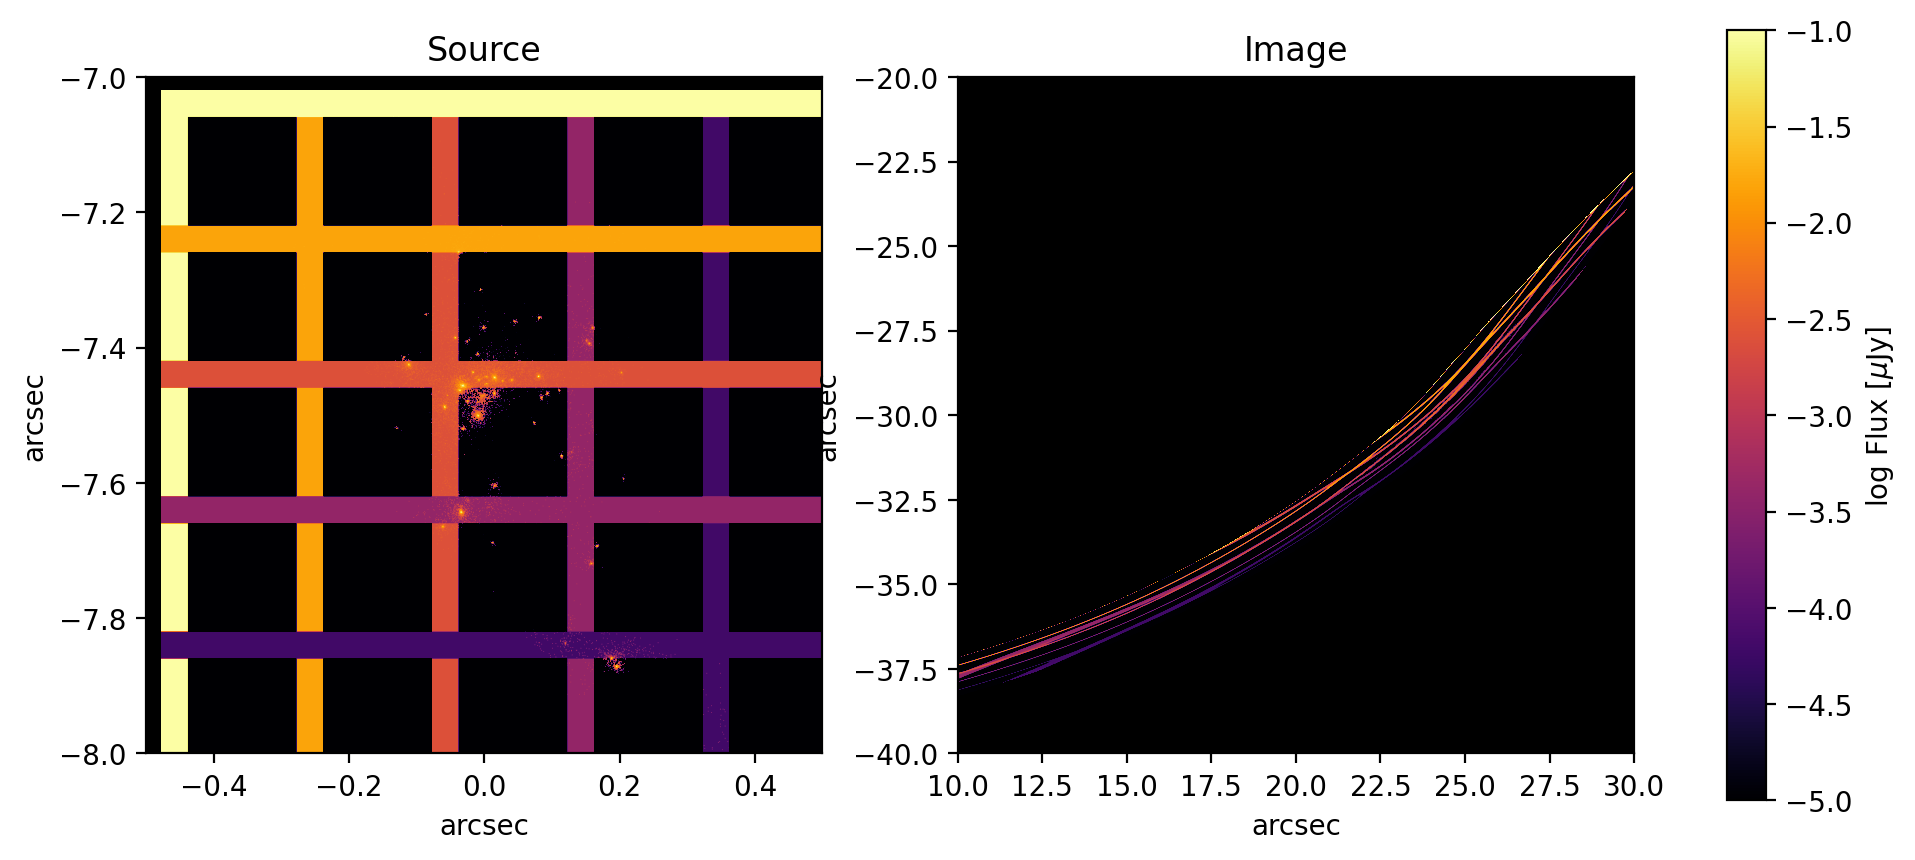

In [8]:
grid_image = al.Array2D.no_mask(create_grid(1000,200,40,True)+galaxy_image.native,pixel_scales=0.001)
# lens image
lensed_image = ndimage.map_coordinates(grid_image.native, traced_grid, order=1, cval=float('nan'))
lensed_image = np.reshape(lensed_image, (-1, int(reco_image_fov / detector_arcsec_per_pxl)))

# plot source image
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
im1 = plot_image(grid_image.native,source_center,source_fov,ax[0],"Source")
im2 = plot_image(lensed_image,image_center,reco_image_fov,ax[1],"Image")
fig.colorbar(im2, ax=ax, label="log Flux [$\mu$Jy]")
# plot center of source plane
# ax[0].scatter(source_center[1],source_center[0],color="yellow",s=1)
# ax[0].scatter(caustic_x,caustic_y,s=0.1)
ax[0].set_xlim([-0.5,0.5])
ax[0].set_ylim([-8,-7])

(-32.5, -27.5)

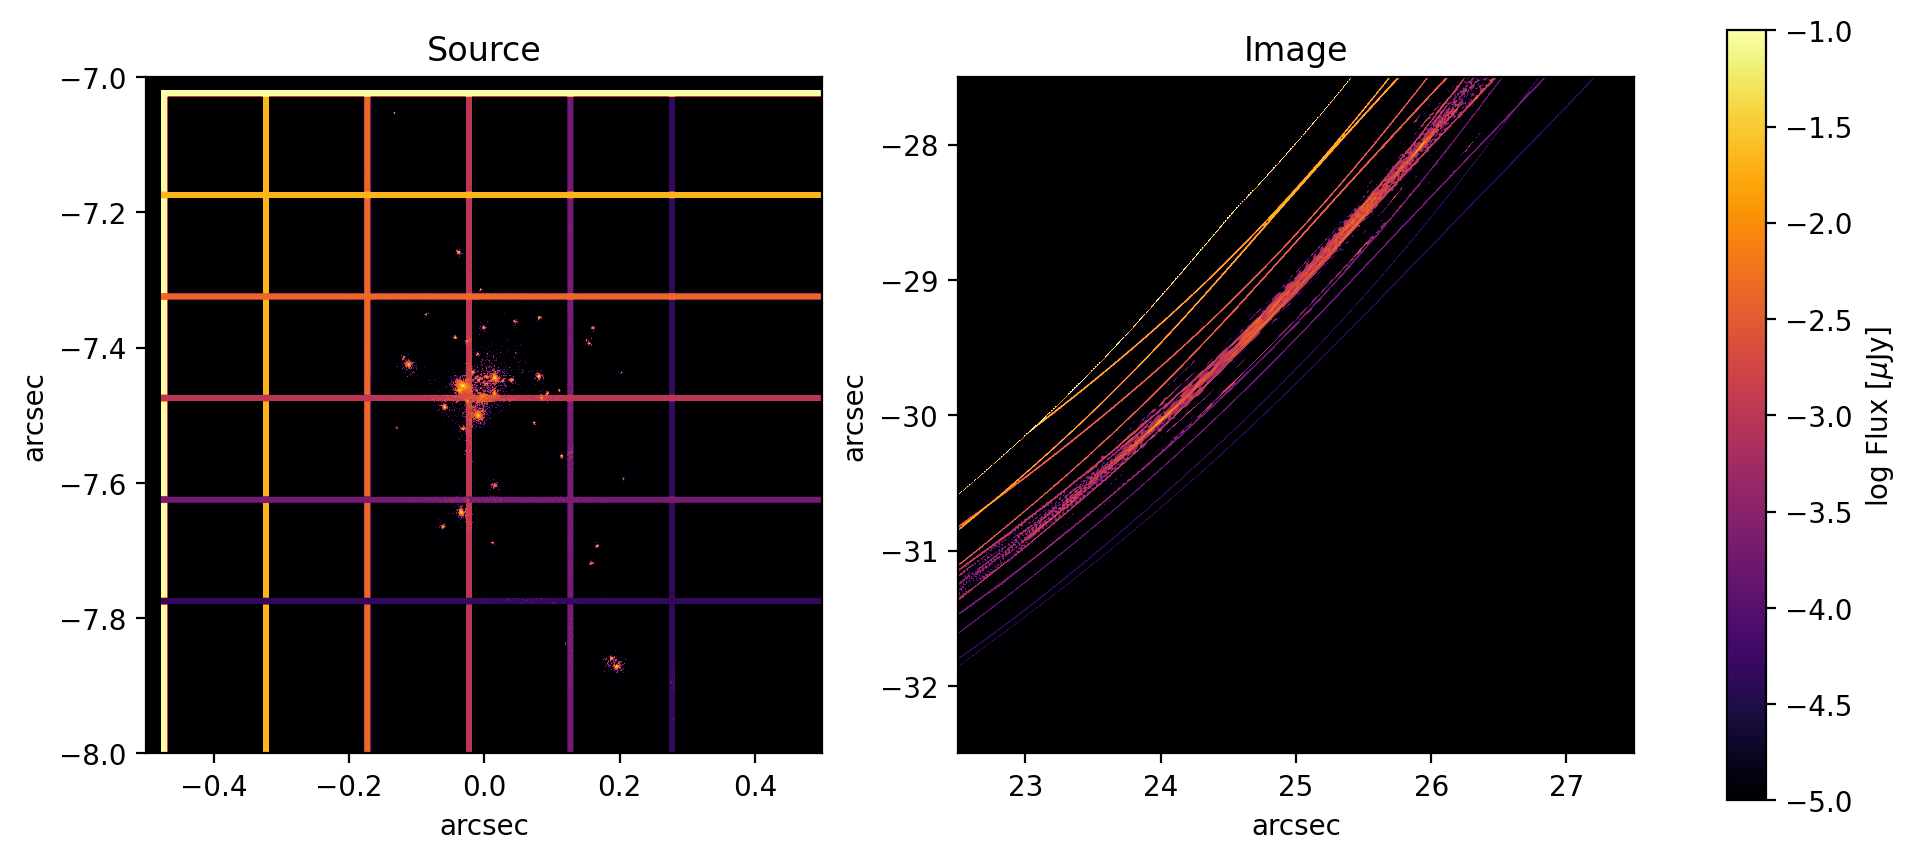

In [9]:
grid_image = al.Array2D.no_mask(create_grid(1000,150,10,True)+galaxy_image.native,pixel_scales=0.001)
# lens image
lensed_image = ndimage.map_coordinates(grid_image.native, traced_grid, order=1, cval=float('nan'))
lensed_image = np.reshape(lensed_image, (-1, int(reco_image_fov / detector_arcsec_per_pxl)))

# plot source image
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
im1 = plot_image(grid_image.native,source_center,source_fov,ax[0],"Source")
im2 = plot_image(lensed_image,image_center,reco_image_fov,ax[1],"Image")
fig.colorbar(im2, ax=ax, label="log Flux [$\mu$Jy]")
# plot center of source plane
# ax[0].scatter(source_center[1],source_center[0],color="yellow",s=1)
# ax[0].scatter(caustic_x,caustic_y,s=0.1)
ax[0].set_xlim([-0.5,0.5])
ax[0].set_ylim([-8,-7])
ax[1].set_xlim([22.5,27.5])
ax[1].set_ylim([-32.5,-27.5])

## Caustic and Critical Line

In [8]:
magnif_line_x = X.flatten()[magnif>200]
magnif_line_y = Y.flatten()[magnif>200]
magnif_line_points = np.column_stack((magnif_line_y,magnif_line_x))

magnif_grid = change_coordinates(magnif_line_points, \
                                 center = (-30,-20), \
                                 fov = reco_image_fov, \
                                 scale = detector_arcsec_per_pxl)
caustic_y = ndimage.map_coordinates(traced_source_plane.native[:,:,0], magnif_grid, order=1, cval=float('nan'))
caustic_x = ndimage.map_coordinates(traced_source_plane.native[:,:,1], magnif_grid, order=1, cval=float('nan'))

(-7.571, -7.471)

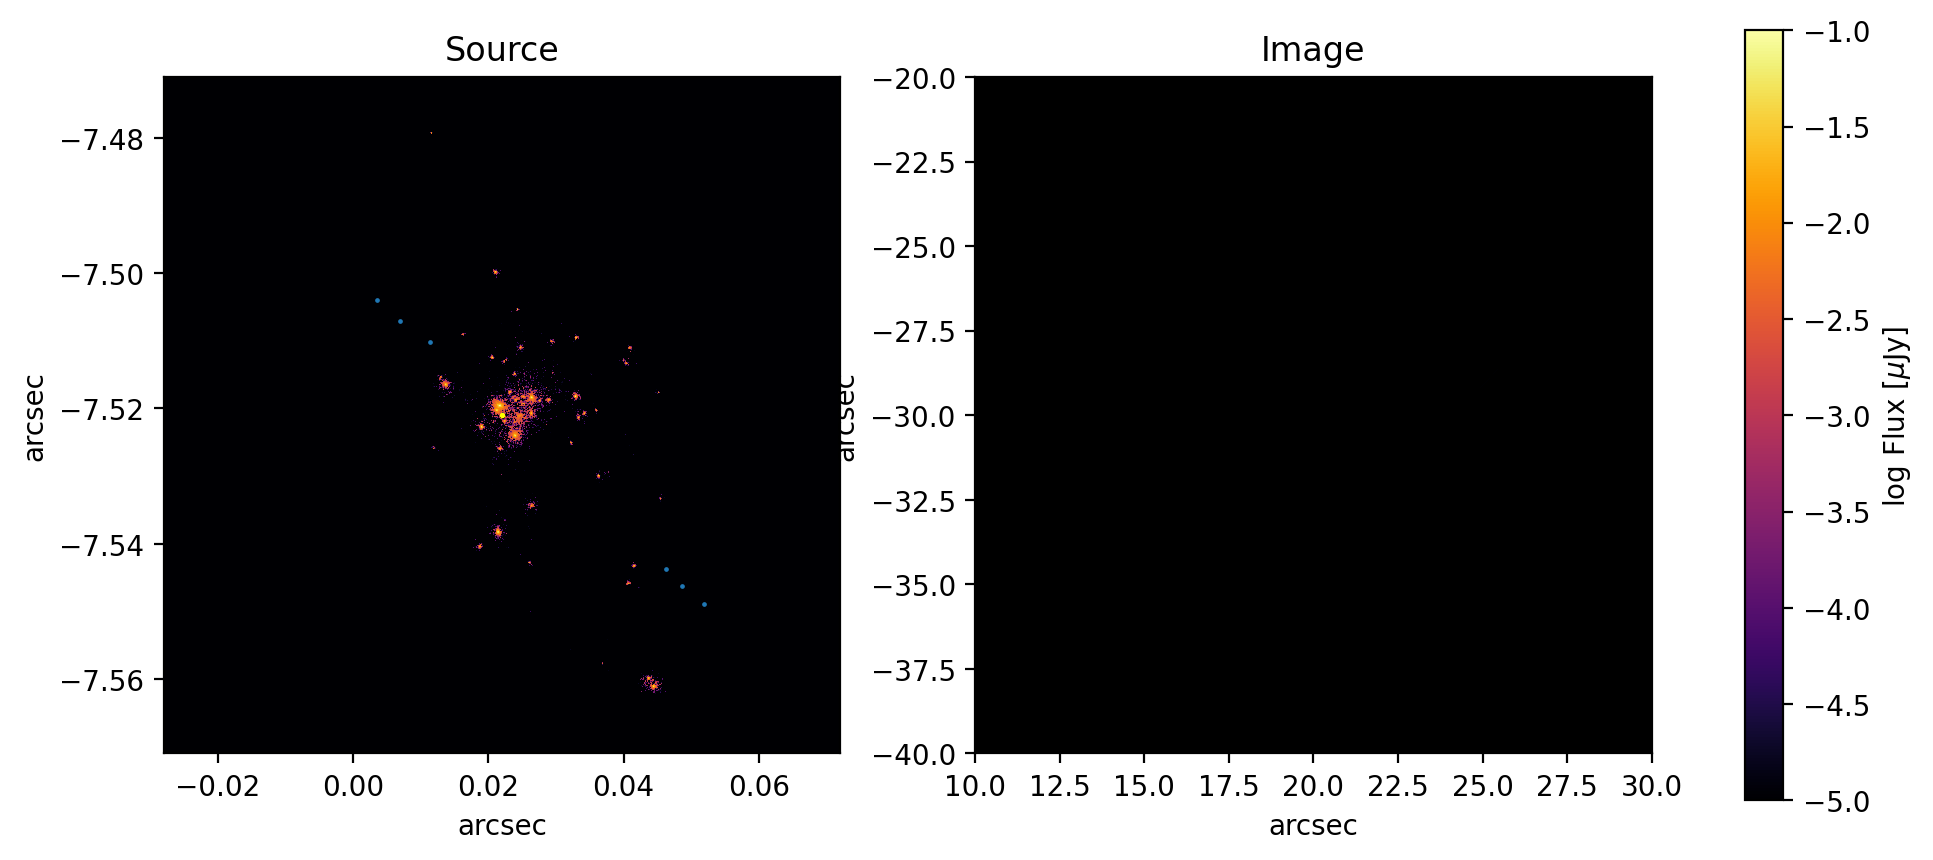

In [19]:
# galaxy_center = (0,0.15)
# galaxy_angle = 5
galaxy_center = (-0.005,0.005)
galaxy_angle = 0

# rotate and shift image
transform = transform_image(galaxy_image, galaxy_angle, galaxy_center, galaxy_image.pixel_scale)

# lens image
lensed_image = ndimage.map_coordinates(transform, traced_grid, order=1, cval=float('nan'))
lensed_image = np.reshape(lensed_image, (-1, int(reco_image_fov / detector_arcsec_per_pxl)))

# plot source image
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

# ax[1].contourf(X,Y,magnif.native,levels=[1000,100000],zorder=2, \
#                            cmap="Reds",alpha=0.7,vmax=80000)

im1 = plot_image(transform,source_center,source_fov,ax[0],"Source")
im2 = plot_image(lensed_image,image_center,reco_image_fov,ax[1],"Image")
fig.colorbar(im2, ax=ax, label="log Flux [$\mu$Jy]")

# plot center of source plane
ax[0].scatter(source_center[1],source_center[0],color="yellow",s=1)

# plot caustic on source plane
ax[0].scatter(caustic_x,caustic_y,s=0.5)

ax[0].set_xlim([0.022-0.05,0.022+0.05])
ax[0].set_ylim([-7.521-0.05,-7.521+0.05])

In [12]:
# break magnification line into 3 segments and trace each one separately
magnif1_x = magnif_line_x[magnif_line_x > 23]
magnif1_y = magnif_line_y[magnif_line_x > 23]
magnif1 = np.column_stack((magnif1_y, magnif1_x))

magnif_grid1 = change_coordinates(magnif1, \
                                 center = (-30,-20), \
                                 fov = reco_image_fov, \
                                 scale = detector_arcsec_per_pxl)
caustic1_y = ndimage.map_coordinates(traced_source_plane.native[:,:,0], magnif_grid1, order=1, cval=float('nan'))
caustic1_x = ndimage.map_coordinates(traced_source_plane.native[:,:,1], magnif_grid1, order=1, cval=float('nan'))

In [13]:
magnif2_x = magnif_line_x[(magnif_line_x < 23) & (magnif_line_x > 16)]
magnif2_y = magnif_line_y[(magnif_line_x < 23) & (magnif_line_x > 16)]
magnif2 = np.column_stack((magnif2_y, magnif2_x))

magnif_grid2 = change_coordinates(magnif2, \
                                 center = (-30,-20), \
                                 fov = reco_image_fov, \
                                 scale = detector_arcsec_per_pxl)
caustic2_y = ndimage.map_coordinates(traced_source_plane.native[:,:,0], magnif_grid2, order=1, cval=float('nan'))
caustic2_x = ndimage.map_coordinates(traced_source_plane.native[:,:,1], magnif_grid2, order=1, cval=float('nan'))

In [14]:
magnif3_x = magnif_line_x[magnif_line_x < 16]
magnif3_y = magnif_line_y[magnif_line_x < 16]
magnif3 = np.column_stack((magnif3_y, magnif3_x))

magnif_grid3 = change_coordinates(magnif3, \
                                 center = (-30,-20), \
                                 fov = reco_image_fov, \
                                 scale = detector_arcsec_per_pxl)
caustic3_y = ndimage.map_coordinates(traced_source_plane.native[:,:,0], magnif_grid3, order=1, cval=float('nan'))
caustic3_x = ndimage.map_coordinates(traced_source_plane.native[:,:,1], magnif_grid3, order=1, cval=float('nan'))

(-8.0, -7.0)

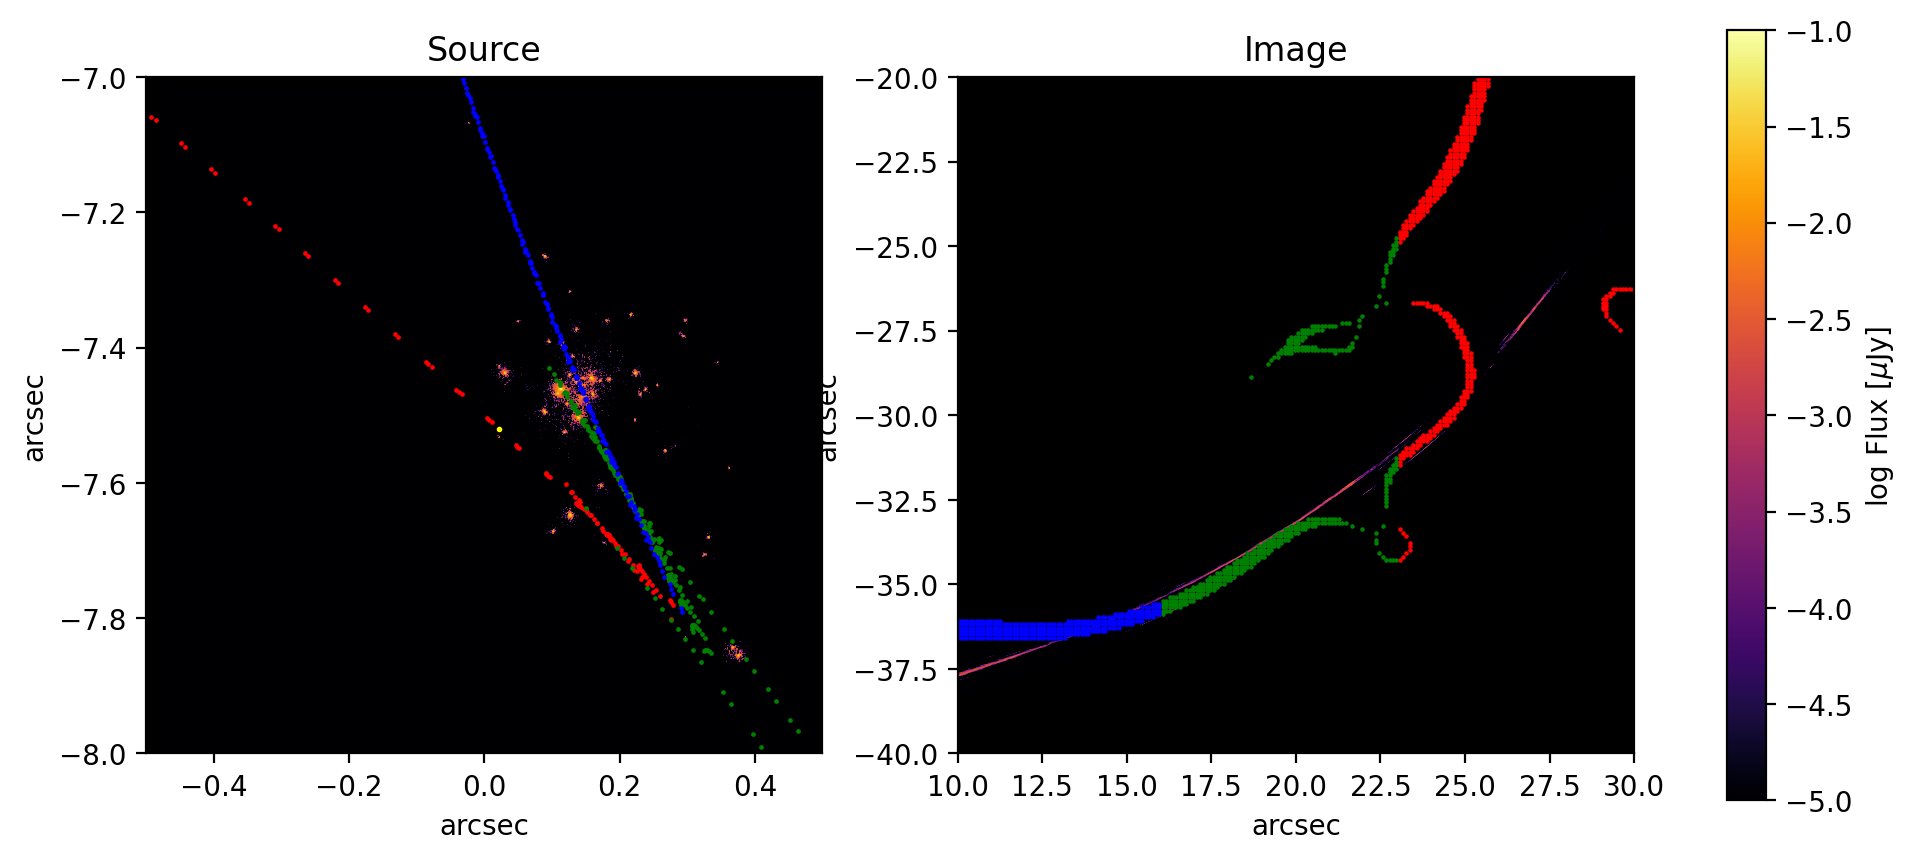

In [15]:
galaxy_center = (0,0.15) # relative to center of source plane
galaxy_angle = 5

# rotate and shift image
transform = transform_image(galaxy_image, galaxy_angle, galaxy_center, galaxy_image.pixel_scale)

# lens image
lensed_image = ndimage.map_coordinates(transform, traced_grid, order=1, cval=float('nan'))
lensed_image = np.reshape(lensed_image, (-1, int(reco_image_fov / detector_arcsec_per_pxl)))

# plot source image
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

# ax[1].contourf(X,Y,magnif.native,levels=[1000,100000],zorder=2, \
#                            cmap="Reds",alpha=0.7,vmax=80000)

# plot magnification line on image plane
ax[1].scatter(magnif1_x,magnif1_y,s=0.4, color='red')
ax[1].scatter(magnif2_x,magnif2_y,s=0.4, color='green')
ax[1].scatter(magnif3_x,magnif3_y,s=0.4, color='blue')

im1 = plot_image(transform,source_center,source_fov,ax[0],"Source")
im2 = plot_image(lensed_image,image_center,reco_image_fov,ax[1],"Image")
fig.colorbar(im2, ax=ax, label="log Flux [$\mu$Jy]")

# plot center of source plane
ax[0].scatter(source_center[1],source_center[0],color="yellow",s=1)

# plot caustic on source plane
ax[0].scatter(caustic1_x,caustic1_y,s=0.5, color="red")
ax[0].scatter(caustic2_x,caustic2_y,s=0.5, color="green")
ax[0].scatter(caustic3_x,caustic3_y,s=0.5, color="blue")
#ax[0].scatter(caustic_x,caustic_y,s=0.5)
ax[0].set_xlim([-0.5,0.5])
ax[0].set_ylim([-8,-7])

## Convolution

In [16]:
from skimage.measure import block_reduce

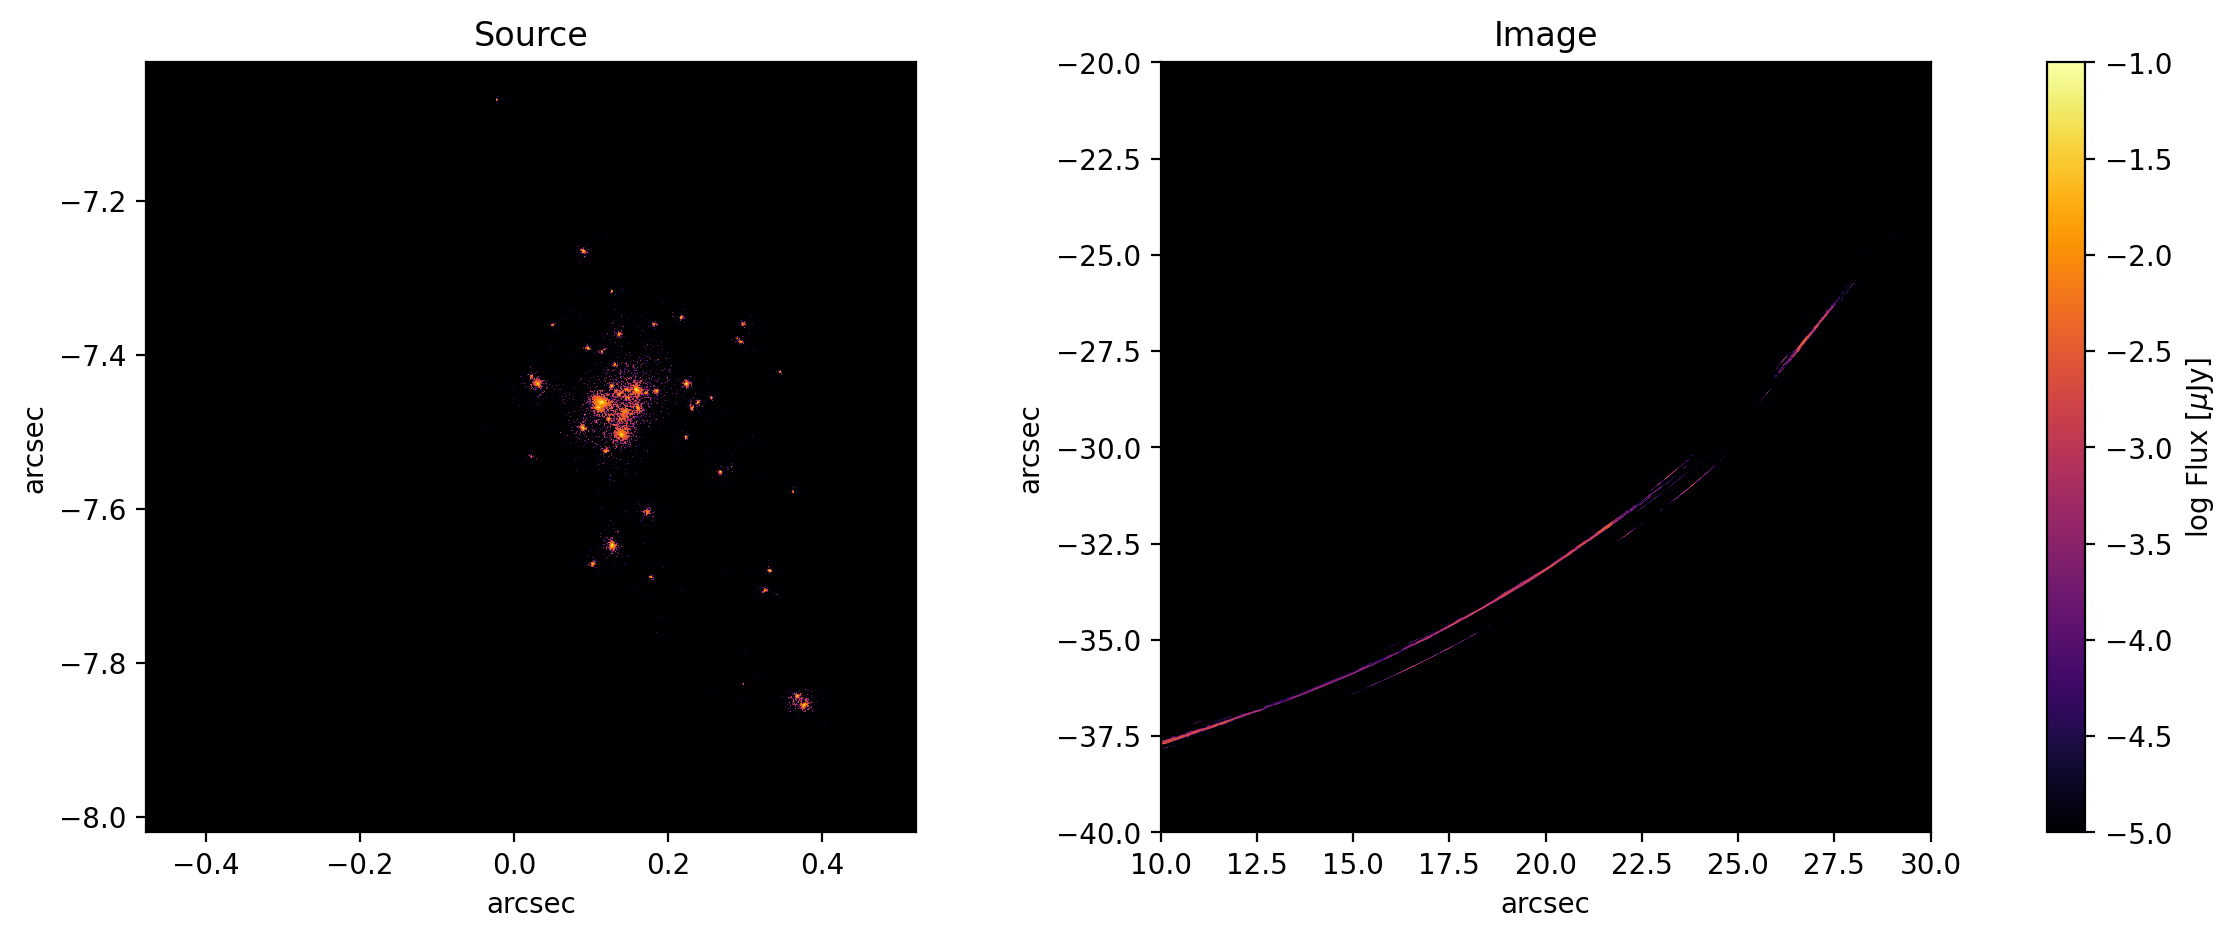

In [21]:
galaxy_center = (0,0.15) # relative to center of source plane
galaxy_angle = 5

# rotate and shift image
transform = transform_image(galaxy_image, galaxy_angle, galaxy_center, galaxy_image.pixel_scale)

# lens image
lensed_image = ndimage.map_coordinates(transform, traced_grid, order=1, cval=float('nan'))
lensed_image = np.reshape(lensed_image, (-1, int(reco_image_fov / detector_arcsec_per_pxl)))

# plot source image
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

im1 = plot_image(transform,source_center,source_fov,ax[0],"Source")
im2 = plot_image(lensed_image,image_center,reco_image_fov,ax[1],"Image")
fig.colorbar(im2, ax=ax, label="log Flux [$\mu$Jy]")

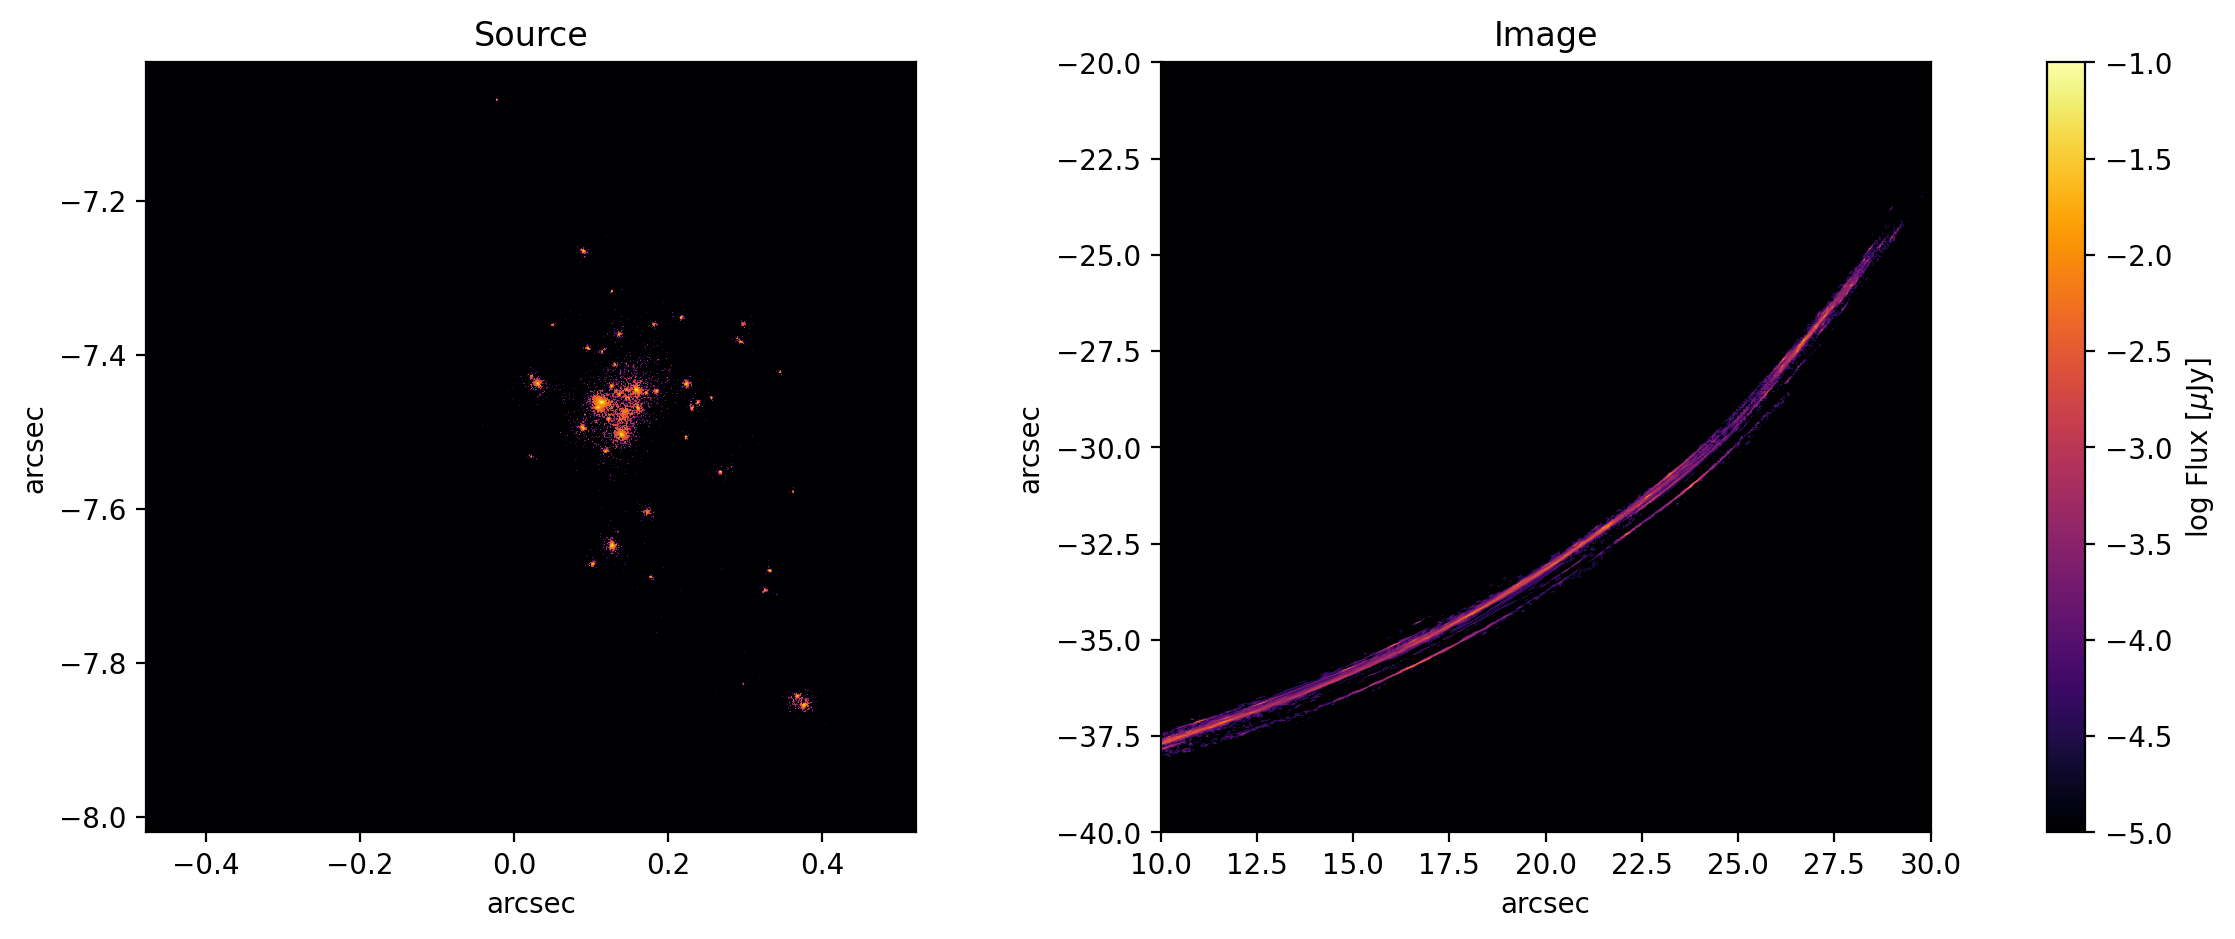

In [19]:
galaxy_center = (0,0.15) # relative to center of source plane
galaxy_angle = 5

# rotate and shift image
transform = transform_image(galaxy_image, galaxy_angle, galaxy_center, galaxy_image.pixel_scale)

# lens image
lensed_image = ndimage.map_coordinates(transform, traced_grid, order=1, cval=float('nan'))
lensed_image = np.reshape(lensed_image, (-1, int(reco_image_fov / detector_arcsec_per_pxl)))

# downsample
lensed_image = block_reduce(np.nan_to_num(lensed_image),block_size=6,func=np.mean)

# plot source image
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

im1 = plot_image(transform,source_center,source_fov,ax[0],"Source")
im2 = plot_image(lensed_image,image_center,reco_image_fov,ax[1],"Image")
fig.colorbar(im2, ax=ax, label="log Flux [$\mu$Jy]")

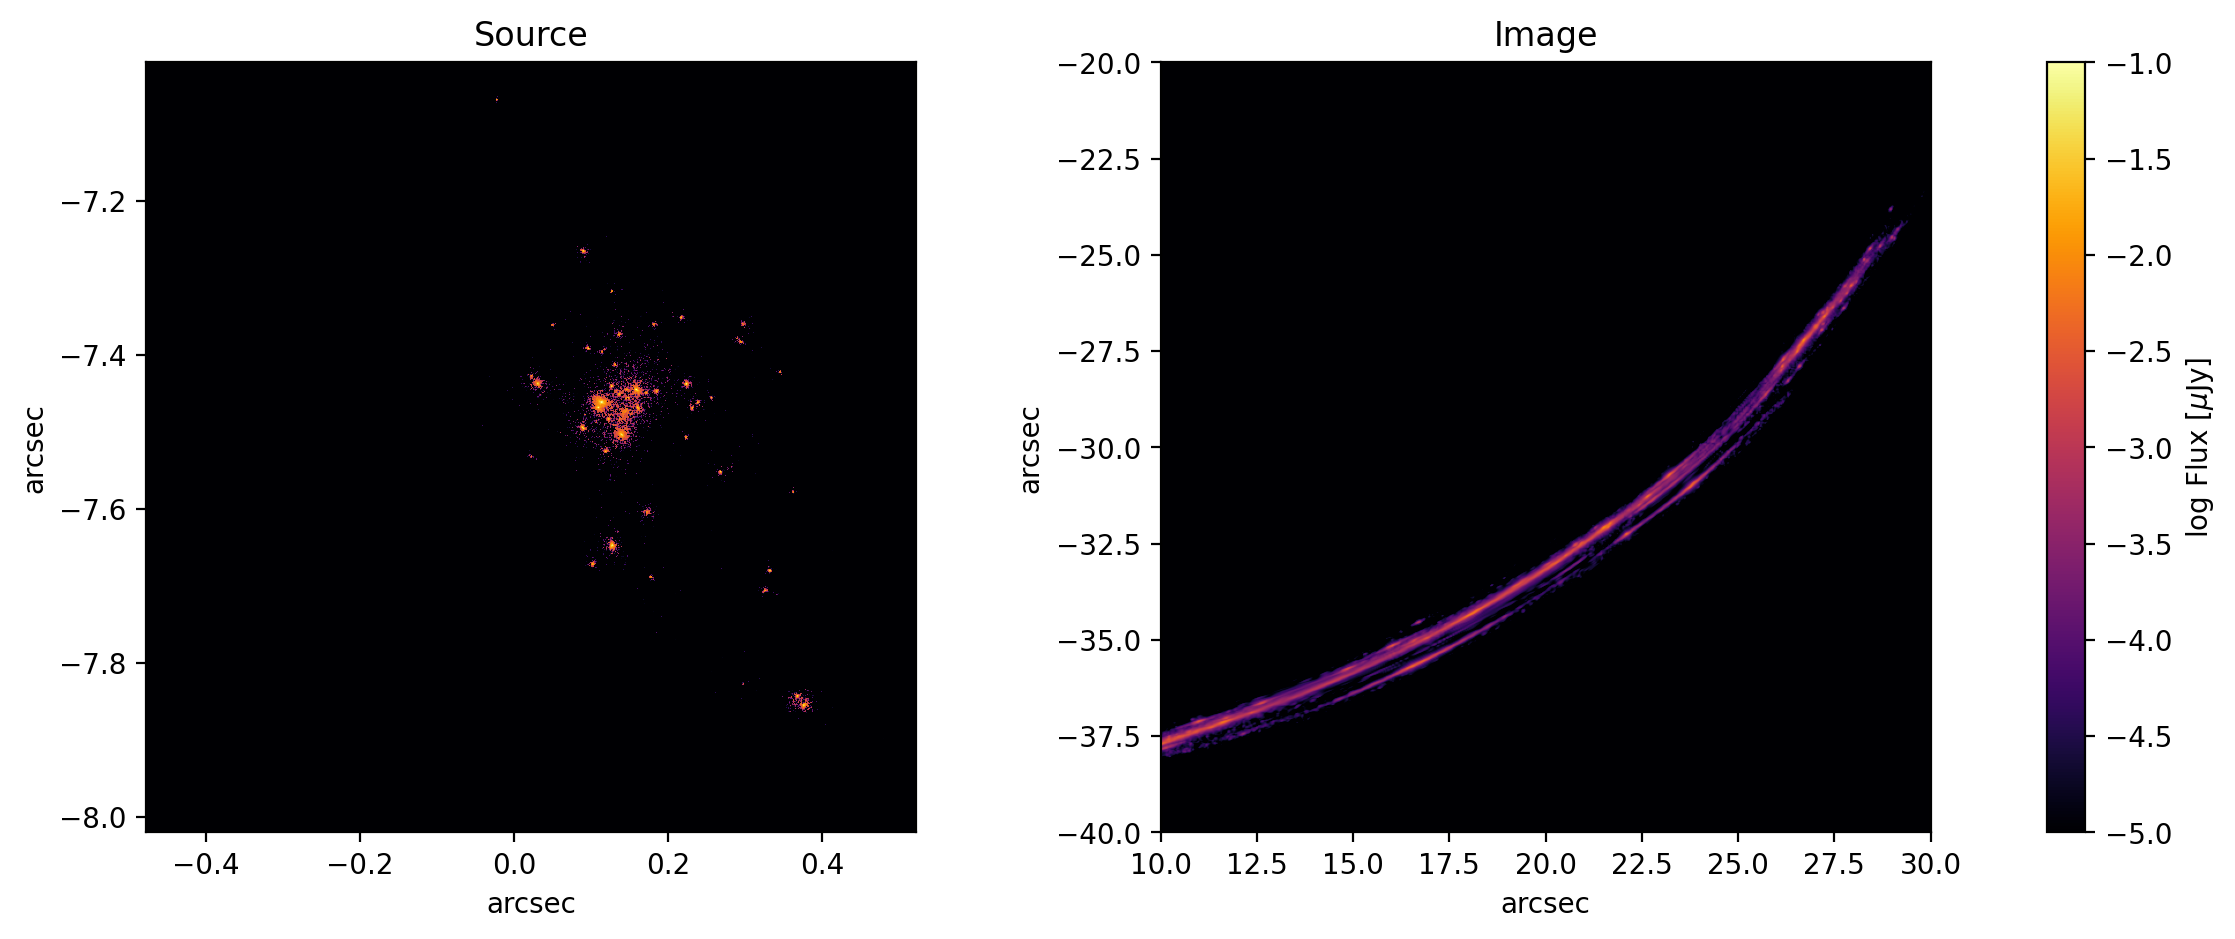

In [22]:
from astropy.convolution import convolve, convolve_fft, AiryDisk2DKernel

# JWST NIRCAM 2 micrometer pixel size = 0.031 as
# https://www.stsci.edu/jwst/instrumentation/imaging-modes
# Airy function radius = 0.05 as
# https://www.stsci.edu/files/live/sites/www/files/home/jwst/documentation/technical-documents/_documents/JWST-STScI-001157.pdf

galaxy_center = (0,0.15) # relative to center of source plane
galaxy_angle = 5

# rotate and shift image
transform = transform_image(galaxy_image, galaxy_angle, galaxy_center, galaxy_image.pixel_scale)

# lens image
lensed_image = ndimage.map_coordinates(transform, traced_grid, order=1, cval=float('nan'))
lensed_image = np.reshape(lensed_image, (-1, int(reco_image_fov / detector_arcsec_per_pxl)))

# convolve image
lensed_image = convolve(lensed_image, AiryDisk2DKernel(10),fill_value=0,nan_treatment='fill')

# downsample image
lensed_image = block_reduce(np.nan_to_num(lensed_image),block_size=6,func=np.mean)

# plot source image
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

im1 = plot_image(transform,source_center,source_fov,ax[0],"Source")
im2 = plot_image(lensed_image,image_center,reco_image_fov,ax[1],"Image")
fig.colorbar(im2, ax=ax, label="log Flux [$\mu$Jy]")

## Animation

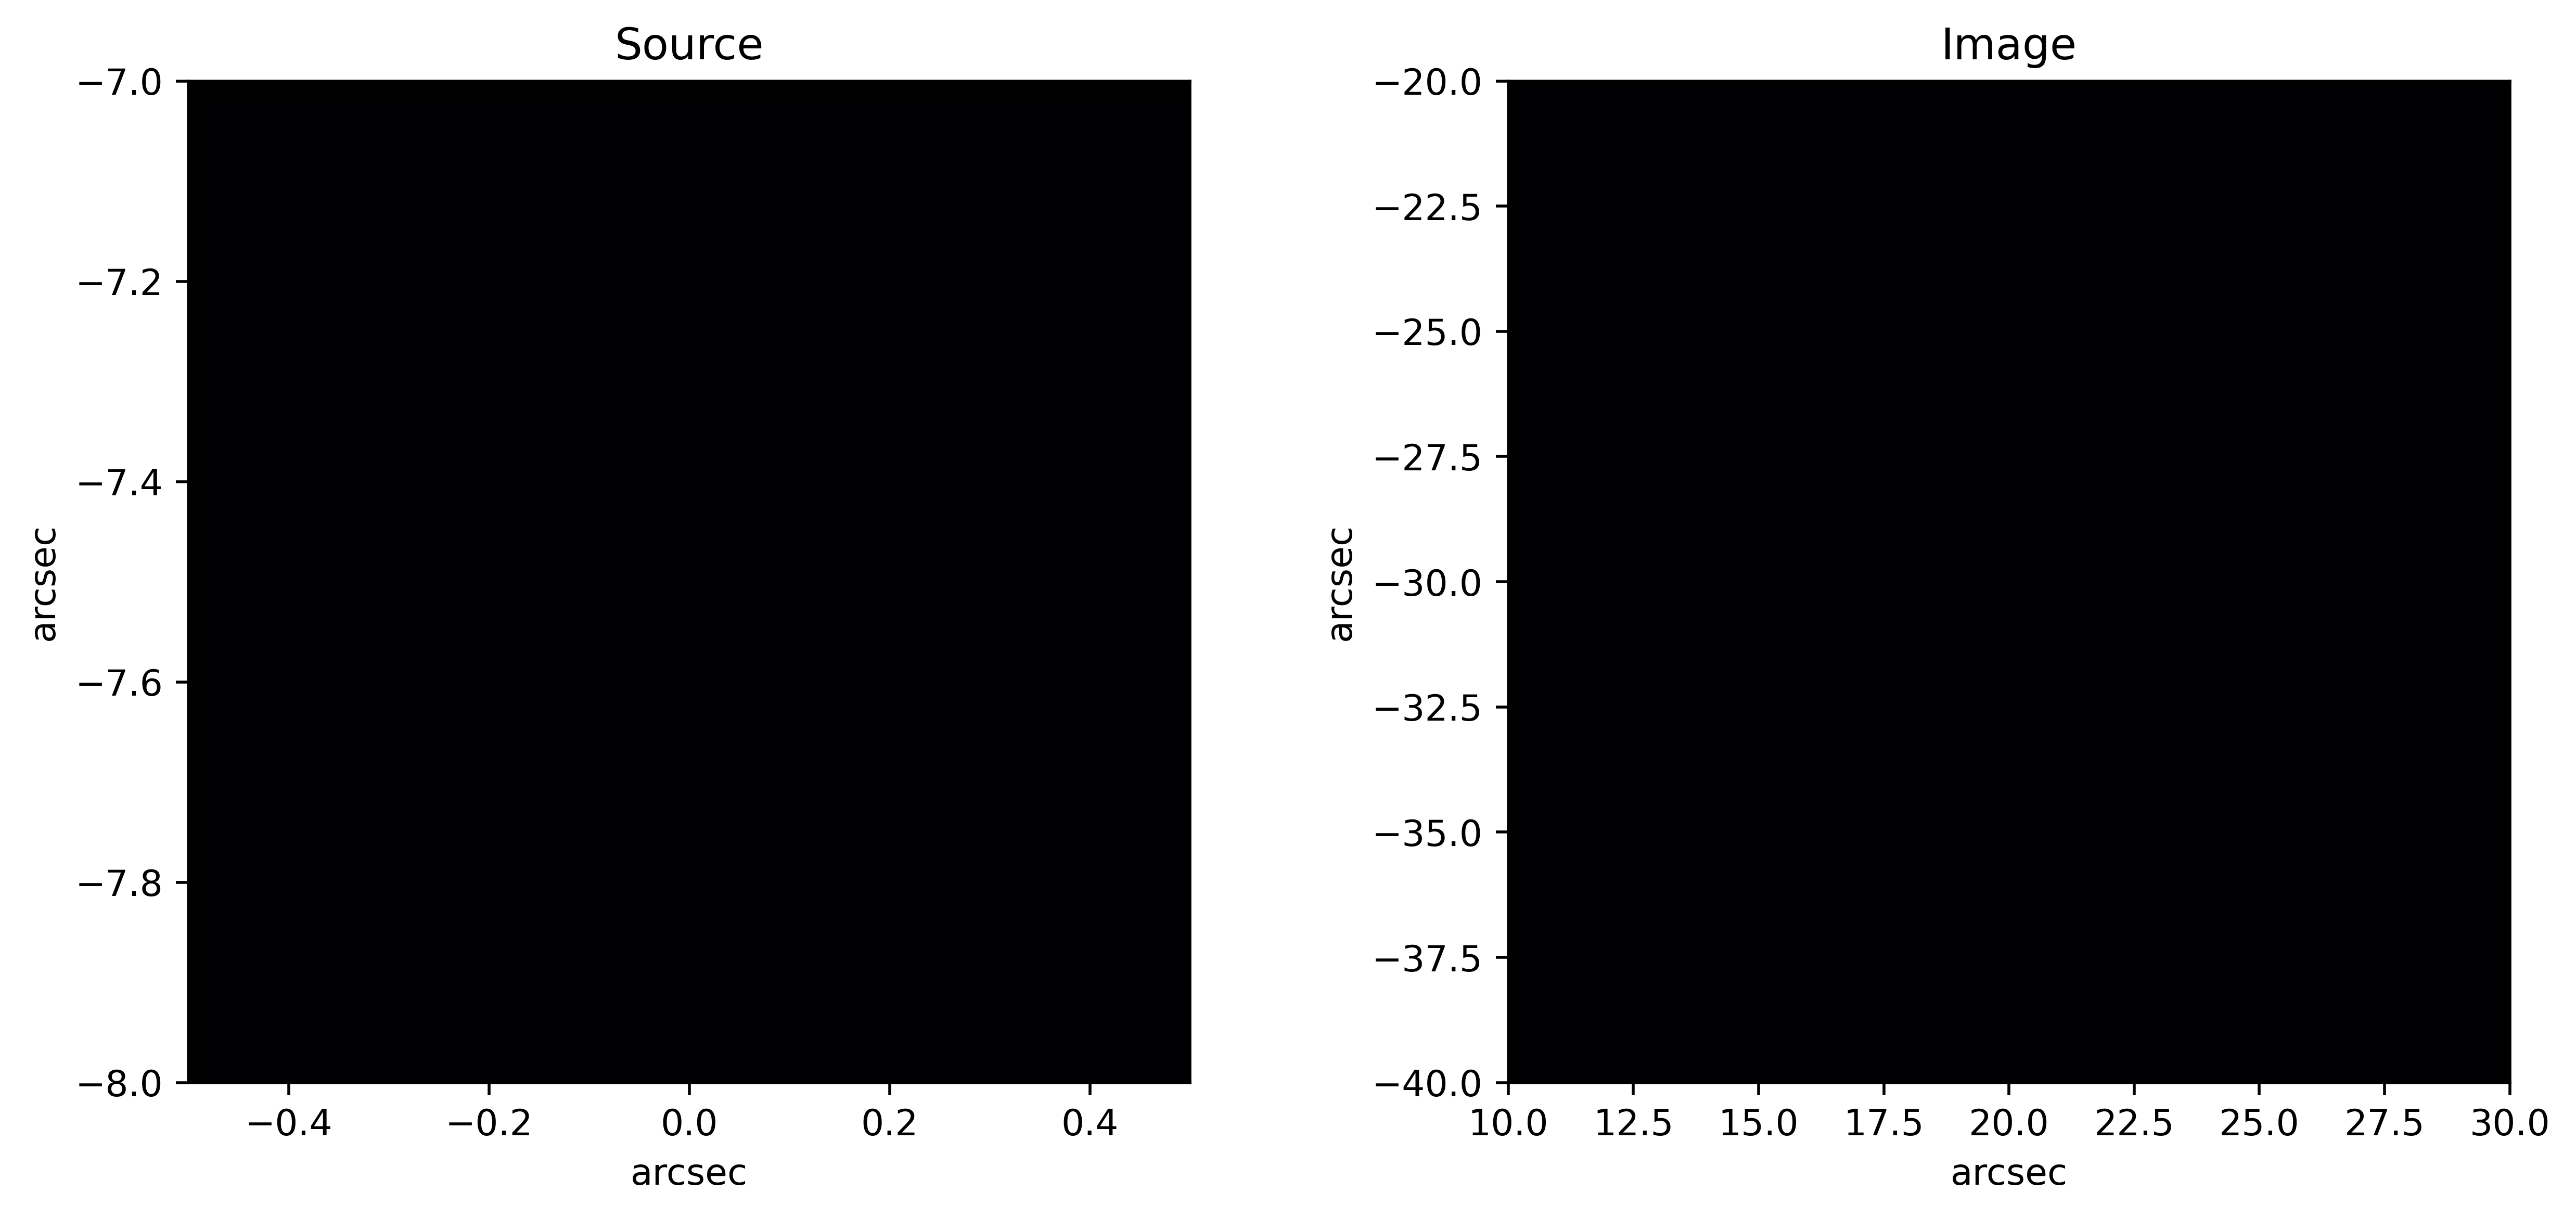

In [21]:
import matplotlib.animation as animation
%matplotlib inline

# starting point
galaxy_center = (0.015,0.015)
galaxy_angle = -70
#galaxy_angle = 15
#galaxy_angle = 0

transform = transform_image(galaxy_image, galaxy_angle, galaxy_center, galaxy_image.pixel_scale)

fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=500)

# plot center of source plane
# ax[0].scatter(source_center[1],source_center[0],color="yellow",s=1,zorder=10)
# ax[0].scatter(caustic_x,caustic_y,s=0.1)
ax[1].contourf(X,Y,np.log(kappa.native),levels=200,cmap="bone",vmin=0,zorder=-1)
# ax[1].contourf(X,Y,magnif.native,levels=[1000,100000],zorder=2, \
#                            cmap="Reds",alpha=0.7,vmax=80000)


im1 = plot_image(np.zeros((source_pix,source_pix)),source_center,source_fov,ax[0],"Source")
im2 = plot_image(np.zeros((image_pix,image_pix)),image_center,reco_image_fov,ax[1],"Image")

ax[0].set_xlim([-0.5,0.5])
ax[0].set_ylim([-8,-7])
ax[1].set_xlim([10,30])
ax[1].set_ylim([-40,-20])

def init():
    return [im1,im2]

def animate(i):
    #galaxy_center = (-0.2+0.6*i/360,-0.2+0.6*i/360)
    #galaxy_center = (-0.01+0.4*i/200,0.015-0.4*i/200)
    #galaxy_center = (0.5*i/360,0.15-0.15*i/360)
    galaxy_angle = i
    transform = transform_image(galaxy_image, galaxy_angle, galaxy_center, galaxy_image.pixel_scale)
    lensed_image = ndimage.map_coordinates(transform, traced_grid, order=1, cval=float('nan'))
    lensed_image = np.reshape(lensed_image, (-1, int(reco_image_fov / detector_arcsec_per_pxl))
    )
    array1 = np.log10(transform, where=(transform != 0), out=np.full_like(transform, -15))+6
    array2 = np.log10(lensed_image, where=(lensed_image != 0), out=np.full_like(lensed_image, -15))+6
    im1.set_array(array1)
    im2.set_array(array2)
    return [im1,im2]

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=360, interval=100, blit=True)

In [22]:
FFwriter = animation.FFMpegWriter(fps=20)
anim.save('rotate.mp4', writer = FFwriter)

2023-08-10 13:48:26,738 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-08-10 13:48:26,744 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 6000x2500 -pix_fmt rgba -r 20 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y rotate.mp4
